In [16]:
import math

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [17]:
#print(train_data.shape) #(12968, 21)
#print(heldout_data.shape) #(4323, 21)
#print(test_data.shape) #(4322, 21)

# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [18]:
# 최신 연도로 바꾸고 기존 yr_bult, yr_renovated 삭제
train_data['yr_max'] = np.maximum(np.array(train_data.yr_built), np.array(train_data.yr_renovated))
train_data = train_data.drop(['yr_built','yr_renovated'], axis=1)

heldout_data['yr_max'] = np.maximum(np.array(heldout_data.yr_built), np.array(heldout_data.yr_renovated))
heldout_data = heldout_data.drop(['yr_built','yr_renovated'], axis=1)

test_data['yr_max'] = np.maximum(np.array(test_data.yr_built), np.array(test_data.yr_renovated))
test_data = test_data.drop(['yr_built','yr_renovated'], axis=1)

In [19]:
# -drop
train_data['zipcode'] = -train_data['zipcode']
heldout_data['zipcode'] = -heldout_data['zipcode']
test_data['zipcode'] = -test_data['zipcode']

In [20]:
e, pi, r2, re = math.e, math.pi, 2 ** 0.5, math.e ** 0.5

## apple lambda exp. for each features
# bathrooms
train_data['bathrooms'] = train_data['bathrooms'].apply(lambda x: x**r2)
# sqft_lot
train_data['sqft_lot'] = train_data['sqft_lot'].apply(lambda x: x**(1/pi))
# floors
train_data['floors'] = train_data['floors'].apply(lambda x: x**(1/(pi**pi)))
# waterfront
train_data['waterfront'] = train_data['waterfront'].apply(lambda x: x**(e**e))
# condition
train_data['condition'] = train_data['condition'].apply(lambda x: x**(pi**2))
# grade
train_data['grade'] = train_data['grade'].apply(lambda x: x**(re**re))
# sqft_basement
train_data['sqft_basement'] = train_data['sqft_basement'].apply(lambda x: x**(r2**r2))
# lat
train_data['lat'] = train_data['lat'].apply(lambda x: x**(1/(pi**pi)))
# sqft_lot15
train_data['sqft_lot15'] = train_data['sqft_lot15'].apply(lambda x: x**(1/pi))
# yr_max
train_data['yr_max'] = train_data['yr_max'].apply(lambda x: x**(e**2))


# bathrooms
heldout_data['bathrooms'] = heldout_data['bathrooms'].apply(lambda x: x**r2)
# sqft_lot
heldout_data['sqft_lot'] = heldout_data['sqft_lot'].apply(lambda x: x**(1/pi))
# floors
heldout_data['floors'] = heldout_data['floors'].apply(lambda x: x**(1/(pi**pi)))
# waterfront
heldout_data['waterfront'] = heldout_data['waterfront'].apply(lambda x: x**(e**e))
# condition
heldout_data['condition'] = heldout_data['condition'].apply(lambda x: x**(pi**2))
# grade
heldout_data['grade'] = heldout_data['grade'].apply(lambda x: x**(re**re))
# sqft_basement
heldout_data['sqft_basement'] = heldout_data['sqft_basement'].apply(lambda x: x**(r2**r2))
# lat
heldout_data['lat'] = heldout_data['lat'].apply(lambda x: x**(1/(pi**pi)))
# sqft_lot15
heldout_data['sqft_lot15'] = heldout_data['sqft_lot15'].apply(lambda x: x**(1/pi))
# yr_max
heldout_data['yr_max'] = heldout_data['yr_max'].apply(lambda x: x**(e**2))


# bathrooms
test_data['bathrooms'] = test_data['bathrooms'].apply(lambda x: x**r2)
# sqft_lot
test_data['sqft_lot'] = test_data['sqft_lot'].apply(lambda x: x**(1/pi))
# floors
test_data['floors'] = test_data['floors'].apply(lambda x: x**(1/(pi**pi)))
# waterfront
test_data['waterfront'] = test_data['waterfront'].apply(lambda x: x**(e**e))
# condition
test_data['condition'] = test_data['condition'].apply(lambda x: x**(pi**2))
# grade
test_data['grade'] = test_data['grade'].apply(lambda x: x**(re**re))
# sqft_basement
test_data['sqft_basement'] = test_data['sqft_basement'].apply(lambda x: x**(r2**r2))
# lat
test_data['lat'] = test_data['lat'].apply(lambda x: x**(1/(pi**pi)))
# sqft_lot15
test_data['sqft_lot15'] = test_data['sqft_lot15'].apply(lambda x: x**(1/pi))
# yr_max
test_data['yr_max'] = test_data['yr_max'].apply(lambda x: x**(e**2))

In [21]:
# normalize features and prices
nor_train = train_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())
nor_heldout = heldout_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())

nor_log_train_price = np.log(train_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / x.std())
nor_log_heldout_price = np.log(heldout_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / x.std())

nor_test = test_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())

In [22]:
# log(price) - mean, std for make predictions
train_log_label_mean, train_log_label_std = np.log(train_data.iloc[:, 2]).mean(), np.log(train_data.iloc[:, 2]).std()
print(train_log_label_mean, train_log_label_std)

heldout_log_label_mean, heldout_log_label_std = np.log(heldout_data.iloc[:, 2]).mean(), np.log(heldout_data.iloc[:, 2]).std()
print(heldout_log_label_mean, heldout_log_label_std)

uni_log_label_mean = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).mean()
uni_log_label_std = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).std()
print(uni_log_label_mean, uni_log_label_std)

13.04810655020148 0.5220080959315785
13.048257499579405 0.5355929705203868
13.048144289728448 0.5254218546587482


In [23]:
# concat train dataest and heldout dataset
nor_train = pd.concat((nor_train, nor_heldout))
nor_labels = pd.concat((nor_log_train_price, nor_log_heldout_price))
# numpy to tensor
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
train_labels = torch.tensor(nor_labels.values.reshape(-1, 1), dtype=torch.float32)

test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

In [24]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]


class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [25]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 1024
epochs = 4000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200,300,400,500,600,800,1000,1200,1400,1600,1800,2000,2300,2600,2900,3200, 3500], gamma=0.85)

epoch: 100 -- train_rmse: 0.1498
epoch: 200 -- train_rmse: 0.1431
epoch: 300 -- train_rmse: 0.1423
epoch: 400 -- train_rmse: 0.1377
epoch: 500 -- train_rmse: 0.1353
epoch: 600 -- train_rmse: 0.1336
epoch: 700 -- train_rmse: 0.1305
epoch: 800 -- train_rmse: 0.1285
epoch: 900 -- train_rmse: 0.1290
epoch: 1000 -- train_rmse: 0.1251
epoch: 1100 -- train_rmse: 0.1250
epoch: 1200 -- train_rmse: 0.1230
epoch: 1300 -- train_rmse: 0.1232
epoch: 1400 -- train_rmse: 0.1222
epoch: 1500 -- train_rmse: 0.1197
epoch: 1600 -- train_rmse: 0.1179
epoch: 1700 -- train_rmse: 0.1190
epoch: 1800 -- train_rmse: 0.1188
epoch: 1900 -- train_rmse: 0.1152
epoch: 2000 -- train_rmse: 0.1174
epoch: 2100 -- train_rmse: 0.1146
epoch: 2200 -- train_rmse: 0.1154
epoch: 2300 -- train_rmse: 0.1143
epoch: 2400 -- train_rmse: 0.1126
epoch: 2500 -- train_rmse: 0.1144
epoch: 2600 -- train_rmse: 0.1122
epoch: 2700 -- train_rmse: 0.1121
epoch: 2800 -- train_rmse: 0.1122
epoch: 2900 -- train_rmse: 0.1108
epoch: 3000 -- train_rm

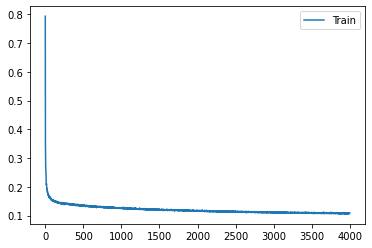

0.1089


In [26]:
train_features, train_labels = train_feats.to(device), train_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_ls = []

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    train_rmse = criterion(net(train_features), train_labels).item()
    train_ls.append(train_rmse)
    
    if (epoch + 1) % 100 == 0:
        print(f'epoch: {epoch + 1} -- train_rmse: {train_rmse:.4f}')
    
    
plt.plot(train_ls, label="Train")
plt.legend()
plt.show()

print(f'{train_ls[-1]:0.4f}')

In [27]:
# making final answer
finals = []

for i in range(3000):
    test_predicts = net(test_feat.to('cuda')).cpu().detach().numpy()
    final_predict = np.exp(test_predicts * uni_log_label_std + uni_log_label_mean)
    finals.append(final_predict)
np.array(finals).mean(axis = 0)

# 134904.32192449123
# 135957.890039547
# 134974.77365882287

array([[667150.8 ],
       [488435.97],
       [213542.14],
       ...,
       [881400.1 ],
       [557788.06],
       [414579.72]], dtype=float32)

In [28]:
test_data = pd.read_csv('dataset/price_data_ts.csv')
test_data['price'] = np.array(finals).mean(axis = 0)

test_data['id'] = test_data['id'].apply(lambda x : str(x) if len(str(x)) == 10 else '0' + str(x) if len(str(x)) == 9 else '00' + str(x))
test_data['id'] = test_data['id'].astype(str) + test_data['date'].astype(str)
submission = pd.concat([test_data['id'], test_data['price']], axis=1)
submission

,id,price
0,700010085020140926T000000,667150.812500
1,403740028020140923T000000,488435.968750
2,142340016020140618T000000,213542.140625
3,776740006020141119T000000,452177.281250
4,946590050020140617T000000,585494.125000
...,...,...
4317,733822037020141006T000000,328168.218750
4318,681910015020140721T000000,624309.875000
4319,082405914020140527T000000,881400.125000
4320,051450009020140513T000000,557788.062500


In [29]:
# making submission file
submission.to_csv('submission_th.csv', index=False)